In [ ]:
!pip install transformers
!pip install fastai

In [2]:
# 라이브러리 import
import torch
import transformers
from transformers import AutoModelWithLMHead, PreTrainedTokenizerFast
from fastai.text.all import *
import fastai
import re

In [3]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# tokenizer 불러오기
tokenizer = PreTrainedTokenizerFast.from_pretrained( 
    "skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>') 

# kogpt2 불러오기
model = AutoModelWithLMHead.from_pretrained("skt/kogpt2-base-v2")
text = '겨울이었습니다.' # 동화 데이터 훈련 전 테스트
input_ids = tokenizer.encode(text)
gen_ids = model.generate(torch.tensor([input_ids]),
                           max_length=128,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True
                        )

generated = tokenizer.decode(gen_ids[0,:].tolist())
print(generated)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


겨울이었습니다.</d> 지난해 12월 31일 오후 2시쯤 서울 강남구 역삼동 한 아파트에서 A(40)씨가 숨진 채 발견됐다.
A씨는 이날 오전 9시경 자신의 집에서 목을 매 스스로 목숨을 끊었다.
경찰은 “아파트 관리사무소에서 ‘숨져 있는 사람이 있다’는 신고를 받고 출동했다”며 “아내가 평소 우울증을 앓아왔다는 유족 진술에 따라 자살로 추정된다”고 밝혔다.
유족들은 경찰 조사 과정에서 “이웃이 자신을 무시하는 것 같아 극단적인 선택을 했다“고 말했다.
한편 이 아파트는 최근 재건축 사업이 추진되면서 철거민들과 마찰을 빚었다. 고인의 빈소는 강남성모


In [5]:
# 동화 데이터 불러오기
with open('/content/drive/MyDrive/kogpt2/fairytale/Total.txt', encoding='UTF8') as f:
   lines = f.read()
lines = " ".join(lines.split())

In [6]:
# 데이터 전처리 함수
def PreProcess(text):
    text = re.sub(pattern=r'\([^)]*\)', repl='', string=text) # 괄호안에 있는 내용 삭제(괄호 포함)
    text = re.sub(pattern='Posted on [0-9]{4} [0-9]{2} [0-9]{2} .+ Posted in \S+ \s?', \
                  repl='', string=text)
    text = re.sub(pattern='Posted on [0-9]{8} .+ Posted in \S+ \s?', \
                  repl='', string=text)
    text = re.sub(pattern='[0-9]{4}년 [0-9]{,2}월 [0-9]{,2}일 [0-9]{,2}시 [0-9]{,2}분 [0-9]{,2}초', \
                  repl='', string=text)
    text = re.sub(pattern='[0-9]{4}. [0-9]{,2}. [0-9]{,2}', \
                  repl='', string=text)
    _filter = re.compile('[ㄱ-ㅣ]+')
    text = _filter.sub('', text)
    _filter = re.compile('[^가-힣 0-9 a-z A-Z \. \, \' \" \? \!]+')
    text = _filter.sub('', text)
    text = re.sub(pattern=r'\s+', repl=' ', string=text) # 다중공백 제거
    return text

In [7]:
# 전처리
fairytale = PreProcess(lines)

In [8]:
# 데이터 확인
fairytale[:256]

'어느 어느 무척 아름다운 시골에. 물론 여름이고요. 들판의 밀밭들이 황금으로 물들었고, 귀리의 잔이삭들이 초록빛깔로 머금은, 푸르른 목초지들엔 풀들이 큰 작대기마냥 서 있는 시골요. 그곳에 기다란 붉은 색 발로 땅을 디디며 황새가 주변을 걸어 다니며 이집트 말로 뭐라뭐라 떠들고 있어요. 아마도 자신의 장모님에게서 이집트 말을 배웠다죠. 이곳 목초지들과 옥수수밭들을 빙 돌아가며 울창한 산림이 쳐져 있고요, 그 숲 한 가운데에 깊은 호수가 하나 있었어요. 그'

In [9]:
# 전처리가 완료된 데이터 tokenizer
class TransformersTokenizer(Transform):
   def __init__(self, tokenizer): self.tokenizer = tokenizer
   def encodes(self, x): 
       toks = self.tokenizer.tokenize(x)
       return tensor(self.tokenizer.convert_tokens_to_ids(toks))
   def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

# 데이테셋 나누기
train=fairytale[:int(len(lines)*0.8)]
test=fairytale[int(len(lines)*0.8):]
splits = [[0],[1]]

# init dataloader
tls = TfmdLists([train,test], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
batch,seq_len = 8,256
dls = tls.dataloaders(bs=batch, seq_len=seq_len)

In [10]:
len(train), len(test)

(1086968, 205972)

SuggestedLRs(valley=5.248074739938602e-05)


epoch,train_loss,valid_loss,perplexity,time
0,5.101895,5.335279,207.530533,01:40


epoch,train_loss,valid_loss,perplexity,time
0,4.000365,4.866799,129.904404,01:41
1,3.832507,5.186745,178.885284,01:42
2,3.298854,5.274736,195.338882,01:43
3,2.579535,5.399806,221.363373,01:42
4,1.812985,5.605871,272.018677,01:43
5,1.312140,5.593851,268.768555,01:43


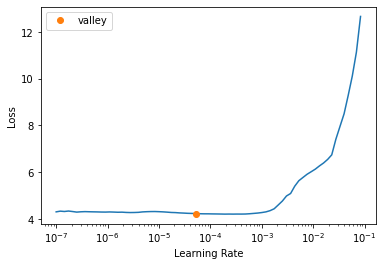

In [11]:
# 데이터 학습
class DropOutput(Callback):
  def after_pred(self): self.learn.pred = self.pred[0]
      
      
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
lr=learn.lr_find()
print(lr)
learn.fine_tune(6)

In [15]:
# 학습된 모델 테스트
prompt="겨울이었습니다."
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,
                           max_length=128,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,       
                           use_cache=True
                          ) 
tokenizer.decode(preds[0].cpu().numpy())

'겨울이었습니다. 그래서 그가 말했어요. "그렇담 이리로 좀 와주련." 그치만 그는 워낙 높은 걸 몰랐고 그럼 어디를 가야 할지 모를 정도였죠. 결국 말은 죽을 때까지 마음껏 먹었지요, 하지만 곧 겨울이 다가오지 않기로 작정을 했기에 사람들은 여인을 짜증나게 놀라고 불렀답니다. 그러자 그녀가 소리쳤<unk>! "이봐,"라며 여인이 탄식하며 외치는 거예요함 질렀지만 소용없습니다만, 그래도 그녀는 남편을 계단 아래로 내려눕곤 거기서 꿈쩍도 하지 않았기에, 남편은 장례식 날 먼지나이 쓴 멋진 고양이 한 마리를 안고 태어났'

In [16]:
# 학습된 모델 저장
learn.model.save_pretrained("kogpt2fairytale")